### CAPSTONE PROJECT | Text cleaning and organization

## Preparation

### Librearies and formatting

In [33]:
#Libraries
!pip install langdetect
import pandas as pd
from langdetect import detect
from google.colab import drive
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import operator
import string
import nltk

from collections import Counter

#Formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Read Files

In [34]:
drive.mount("/google_drive")
WORKSPACE_PATH = "/google_drive/My Drive/MBD Capstone"


xls = pd.ExcelFile(WORKSPACE_PATH+ '/ie_input_data IIII.xlsx')
predictors = pd.read_excel(xls, 'predictors')
labels = pd.read_excel(xls, 'labels')

Drive already mounted at /google_drive; to attempt to forcibly remount, call drive.mount("/google_drive", force_remount=True).


## Cleaning

### Removing from client answers text of Pia

In [35]:
predictors = predictors.reset_index()
predictors_client = predictors[predictors['source']==1]
predictors_pia = predictors[predictors['source']!=1]

In [36]:
valores = '\nHola.*|\nBuen.*|\nSoy .*|\nAgendaste.*|\nTe escribo.*|¿Asistirás.*|Sent:>*|\nMe comunico para confirmar>*|從.*|From.*|El contenido del presente.*|Asistirás.*|Mi nombre es Pía.*'
predictors_client['text'] = predictors_client['text'].str.replace(valores, '',regex = True)

In [37]:
predictors_client[(predictors_client['source']==1) & (predictors_client['text'].str.contains('¿Asistirás|Sent:|\nMe comunico para confirmar|從 ', regex=True)==True) ]

,index,unique_id,channel,subject,text,created,delivered_at,executed_at,read_at,rejected_at,reserved_date,sent_at,updated_at,source,state,Unnamed: 14,Unnamed: 15,Unnamed: 16


In [38]:
predictors = pd.concat([predictors_pia,predictors_client], axis=0)
predictors = predictors.sort_values('index')
predictors = predictors.drop(columns=['index'])

### What Am I deleting here

1. Deleting entirely rows that contain the 👍 emoji. Because that means is a survey sent by the bot and it does not add useful info. 
```
predictors = predictors[predictors.text.str.contains("👍")==False`
``

Example

```
¿Qué te pareció el servicio de confirmación de turnos? <br />Seleccioná el dedo que vaya más acorde a tu respuesta: 
<a href='https://studies.eniax.cl/simple/swissmedical/1/?job_id=62525a604f29b7a467c05713' style='font-size: 32px; text-decoration: none;'>👍</a>&nbsp;&nbsp;&nbsp;<a href='https://studies.eniax.cl/simple/swissmedical/0/?job_id=62525a604f29b7a467c05713' style='font-size: 32px; text-decoration: none;'>👎</a> 

Saludos cordiales,
Pia<br/>Asistente de turnos
Muchas gracias por elegir Swiss Medical Center, Laura.


In [39]:

predictors = predictors[predictors.text.str.contains("👍")==False]
# Deleting hastags
predictors.text = predictors.text.str.replace('\#\S+', '')
# Replacing \n with space 
predictors.text = predictors.text.str.replace('\n', ' ')
# removing other emojis 
emojis_pat = r'[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]'
predictors.text = predictors.text.str.replace(emojis_pat, '', regex=True)
#removing html tags
predictors.text = predictors.text.str.replace('<[^>]*>', ' ') 

### Remove URL
What the next function does is to remove the the URL and all the irrelevant text that comes after it. Some examples: 

**Before:**
```
363     Muchas gracias por tu respuesta Geronimo. Tu turno de Odontopediatría para hoy queda cancelado. Para reagendar ingresa a https://www.swissmedical.com.ar. También puedes hacerlo ingresando a nuestra APP mobile o llamando al 0810-333-8876.       
```                                                                                                                                      
**After** 
```
363     Muchas gracias por tu respuesta Geronimo. Tu turno de Odontopediatría para hoy queda cancelado.    
```
                                                                            
**Before:**                                                                             
                                    
```
390     Hola, buenos días Martha,    Queda cancelado el turno para el martes 26 a las 16:30 horas con Maria Marzorati de Gastroenterología Y Hepatología en Swiss Medical Center Microcentro (25 de Mayo).  Para agendar otro turno ingresa a https://enx.cl/7Md3K. También puedes hacerlo ingresando a nuestra APP mobile o llamando al 0810-333-8876.  Hasta luego,  Saludos, Pia<br/>Asistente de turnos                                                                       
```                                                                                                                                                        
**After**  
```                                                                   
390    Hola, buenos días Martha,    Queda cancelado el turno para el martes 26 a las 16:30 horas con Maria Marzorati de Gastroenterología Y Hepatología en Swiss Medical Center Microcentro (25 de Mayo).                                        
```

                  

In [40]:
def remove_url(row):
    if "http" in row['text']:
      aux = row['text'].split(".")
      text = ""
      for a in aux:
        if "http" not in a:
          text = text + a +"."
        else:
          break
      return text
    else:
      return row['text']
    
predictors["text"] = predictors["text"].astype('str')
predictors["text"] = predictors.apply(remove_url, axis=1)

### Other Cleaning steps
 - Cleaning "Get Outlook para Android"

In [41]:
predictors.text = predictors.text.str.replace('Get Outlook para Android' , '') 
predictors.text = predictors.text.str.replace('Obter Outlook para Android' , '') 

 - Cleaning parts of text that are not interesting

In [42]:
rows_mail = predictors[predictors.text.str.contains("CORREO")==True]['text']

externo_string = 'CORREO EXTERNO: Este e-mail fue enviado desde afuera de Swiss Medical S.A. No hagas click en los links o adjuntos, respondas con información, a menos que reconozcas al remitente y confíes en su contenido.'
predictors.text = predictors.text.str.replace(externo_string , '') 

#rows_mail.index 
for i in rows_mail.index:
  predictors.loc[i,'text'] = predictors.loc[i,'text'].split("El")[0]

### Removing conversations after four hour before the appointment

In [43]:
hours_remove = 0.0001
total_time = hours_remove*3600
print(len(predictors))
predictors = predictors[(predictors['reserved_date']-total_time) > predictors['created']]



7089


## Feature Generation

The messages with Source = 0, 3 are sent by the assistant, while the Source = 1 are from the patient.

**Note:** Checking the balance of the classes. Do you think that we need to do something with this imbalance dataset?

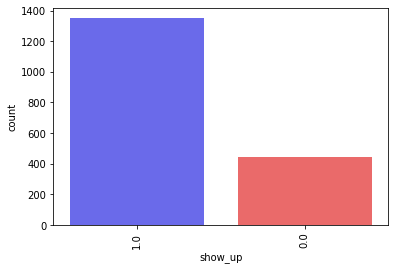

In [44]:
sns.countplot(x=labels.show_up, order=[x for x, count in sorted(Counter(labels.show_up).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

### Creating column `word_count` 

In [45]:
# Just the columns that we need
nlp = predictors[['unique_id','channel','subject','text','source']]

In [46]:
# General word_count column
nlp['word_count'] = nlp['text'].apply(lambda x: len(str(x).split()))

# Just patient word_count
nlp['patient_word_count'] = np.where(nlp['source'] == 1, nlp['text'].apply(lambda x: len(str(x).split())), 0)

# Just 'assistant' word_count
nlp['assistant_word_count'] = np.where(nlp['source'] != 1, nlp['text'].apply(lambda x: len(str(x).split())), 0)

### Creating column `unique_word_count`

In [47]:
# General unique_word_count column
nlp['unique_word_count'] = nlp['text'].apply(lambda x: len(set(str(x).split())))

# Just patient unique_word_count
nlp['patient_unique_word_count'] = np.where(nlp['source'] == 1, nlp['text'].apply(lambda x: len(set(str(x).split()))), 0)

# Just 'assistant' unique_word_count
nlp['assistant_unique_word_count'] = np.where(nlp['source'] != 1, nlp['text'].apply(lambda x: len(set(str(x).split()))), 0)

### Creating column `punctuation_count`

In [48]:
# General punctuation_count column
nlp['punctuation_count'] = nlp['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Just patient unique_word_count
nlp['patient_punctuation_count'] = np.where(nlp['source'] == 1, nlp['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation])), 0)

# Just 'assistant' unique_word_count
nlp['assistant_punctuation_count'] = np.where(nlp['source'] != 1, nlp['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation])), 0)

### Creating a boolean column with `is_assistant` and `is_patient` 

In [49]:
# is_patient
nlp['is_patient'] = np.where(nlp['source'] == 1, 1, 0)

# is_assistant
nlp['is_assistant'] = np.where(nlp['source'] != 1, 1, 0)

### Grouping all the new features by `unique_id`

In [50]:
nlp.columns

Index(['unique_id', 'channel', 'subject', 'text', 'source', 'word_count',
       'patient_word_count', 'assistant_word_count', 'unique_word_count',
       'patient_unique_word_count', 'assistant_unique_word_count',
       'punctuation_count', 'patient_punctuation_count',
       'assistant_punctuation_count', 'is_patient', 'is_assistant'],
      dtype='object')

In [51]:
numeric_data_points= nlp.groupby('unique_id').agg(['mean', 'sum','median'])[['is_assistant', 'is_patient', 'word_count',
                                       'patient_word_count', 'assistant_word_count', 'unique_word_count',
                                       'patient_unique_word_count', 'assistant_unique_word_count',
                                       'punctuation_count', 'patient_punctuation_count',
                                       'assistant_punctuation_count']]
numeric_data_points.columns = numeric_data_points.columns.map('|'.join).str.strip('|')



In [52]:
nlp.groupby('is_patient').mean()

,unique_id,source,word_count,patient_word_count,assistant_word_count,unique_word_count,patient_unique_word_count,assistant_unique_word_count,punctuation_count,patient_punctuation_count,assistant_punctuation_count,is_assistant
is_patient,,,,,,,,,,,,
0,1.082451e+07,0.139015,42.605670,0.000000,42.60567,38.548246,0.000000,38.548246,8.756496,0.000000,8.756496,1.0
1,1.139067e+07,1.000000,6.791753,6.791753,0.00000,6.548454,6.548454,0.000000,1.606186,1.606186,0.000000,0.0


In [53]:
print(nlp['is_assistant'].mean())
print(nlp['is_patient'].mean())

0.7908881862604197
0.20911181373958035


## Transformations

### Only considering last answer

In [54]:
last_answer = nlp.loc[nlp['source']==1,['unique_id','text']]
last_answer = last_answer.drop_duplicates(subset='unique_id',keep='last')
last_answer.columns = ['unique_id','last_answer']

### Group all the conversations by unique_id
 - the texts from the assistant start with a "||" and the texts from patients start with a ";;"

In [55]:
#just answers
group_nlp_client = nlp[nlp['source']==1].groupby(['unique_id'])['text'].apply(lambda x: '||'.join(x)).reset_index()

In [57]:
# Columns that are necessary
# nlp = predictors[['unique_id','channel','subject','text','source']]

# Add the special characters related to each answer
#nlp.loc[:,'type'] = ['{ca}' if source == 1 else '{aa}' for source in nlp['source'] ]
nlp.loc[:,'text'] = nlp.loc[:,'text'].astype('str')
#nlp.loc[:,'text'] = nlp.loc[:,'type'] + nlp.loc[:,'text']

# Create the group by
group_nlp = nlp.groupby(['unique_id'])['text'].apply(lambda x: ' '.join(x)).reset_index()

### Detect the language of the conversation

In [58]:
language = []
for i in group_nlp['text']:
    try:
        val = detect(i)
        language.append(val)
    except:
        val = "error"
        language.append('not detected')

group_nlp['idioma'] = language
print(group_nlp['idioma'].value_counts())

es    1072
pt    721 
Name: idioma, dtype: int64


In [59]:
#Just one conversation is not well assigned, it will be changed manually
group_nlp.loc[group_nlp['idioma'] !='pt','idioma'] = 'es'

In [60]:
#Only spanish
group_nlp= group_nlp[group_nlp['idioma']=='es']

In [62]:
group_nlp.shape

(1072, 3)

In [61]:
group_nlp_client.shape

(1152, 2)

### Merge with other datasets

In [63]:
# Merge with Lables
group_nlp = group_nlp.merge(labels, how = 'inner', on='unique_id')

# Merge with other features
group_nlp_client.columns = ['unique_id','text_answers']
group_nlp = group_nlp.merge(group_nlp_client, how = 'inner', on='unique_id')
group_nlp = group_nlp.merge(last_answer, how = 'left', on='unique_id')
group_nlp['last_answer']= group_nlp['last_answer'].fillna('')

In [64]:
group_nlp.shape

(790, 6)

In [ ]:
group_nlp.to_excel(WORKSPACE_PATH+ '/JLB/validation1.xlsx')

In [ ]:
#Aditional columns
numeric = group_nlp.merge(numeric_data_points, how = 'inner', on='unique_id')

### Eliminate No Answers

In [ ]:
con_no = group_nlp[group_nlp['last_answer'].str.lower().str.contains(' no |^no |cancel')]
con_no.to_excel(WORKSPACE_PATH+ '/analisis_no.xlsx')

In [ ]:
sin_no = group_nlp[~group_nlp['last_answer'].str.lower().str.contains(' no |^no |cancel')]
# Creating two categories for answer length
sin_no['cat_answer'] = np.where(sin_no['last_answer'].str.split(' ').str.len() <=1, '1', '2')

In [ ]:
#Aditional columns
numeric_no = sin_no.merge(numeric_data_points, how = 'inner', on='unique_id')

In [ ]:
df_analysis_word =  sin_no['last_answer'].str.split(' ', expand=True).join(sin_no['show_up'])
df_analysis_word

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,show_up
0,Si,",",gracias.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0
1,Si,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0
2,Si,allí,"estaré!!!,",Gracias,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0
3,Si,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0
4,",si",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0
5,Confirmo,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0
6,Ok,confirmada,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0
7,Si,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0
8,En,la,sala,de,espera,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0
10,Si,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0


## Write File

In [ ]:
group_nlp.to_excel(WORKSPACE_PATH+ '/ie_input_data_no_character.xlsx')


In [ ]:
numeric.to_excel(WORKSPACE_PATH+ '/JLB/numeric_vals.xlsx')

numeric_no.to_excel(WORKSPACE_PATH+ '/JLB/numeric_vals2.xlsx')

In [ ]:
sin_no.to_excel(WORKSPACE_PATH+ '/ie_input_data_no_character_sin_no.xlsx')

In [ ]:
df_analysis_word.to_excel(WORKSPACE_PATH+ '/df_analysis_word.xlsx')